## Context and Objective
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 
Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

Acknowledgments
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

#### What should I expect the data format to be?
Each sample in the train and test set has the following information:

The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)

#### What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

#### Data Columns
id - a unique identifier for each tweet<br>
text - the text of the tweet<br>
location - the location the tweet was sent from (may be blank)<br>
keyword - a particular keyword from the tweet (may be blank)<br>
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [3]:
import pandas as pd 
import numpy as np

from textblob import TextBlob
from textblob import Word

#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import pickle

import pandas_profiling

import string
import re

import nltk
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('punkt')
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier 
from xgboost import XGBClassifier

# Importing Gensim
import gensim
from gensim.parsing.porter import PorterStemmer
from gensim import corpora
from gensim.utils import lemmatize #pip install pattern
import pyLDAvis.gensim
import spacy
from spacy.matcher import Matcher

from tqdm import tqdm
import demoji
#demoji.download_codes()
from collections import defaultdict
from collections import Counter

#Setting plot sizes and type of plot
plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\ProgramData\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


<Figure size 432x216 with 0 Axes>

### load and explore the data

In [4]:
# read train data into a DataFrame
data = pd.read_csv('data/train.csv')

In [5]:
data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
## check for missing values
print("missing values in each columns" , data.isnull().sum(), sep='\n')

missing values in each columns
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [9]:
## check for duplicate rows
print("Number of duplicate rows :" , len(data[data.duplicated(keep=False)]))

Number of duplicate rows : 0


### exploratory analysis

In [10]:
#aggregating tweets over keywords.
Keyword_target = data.groupby(['keyword','target']).agg({'target':['count']})
Keyword_target.columns = ["_".join(x) for x in Keyword_target.columns.ravel()]
Keyword_target.reset_index(inplace = True)
Keyword_target.shape

(438, 3)

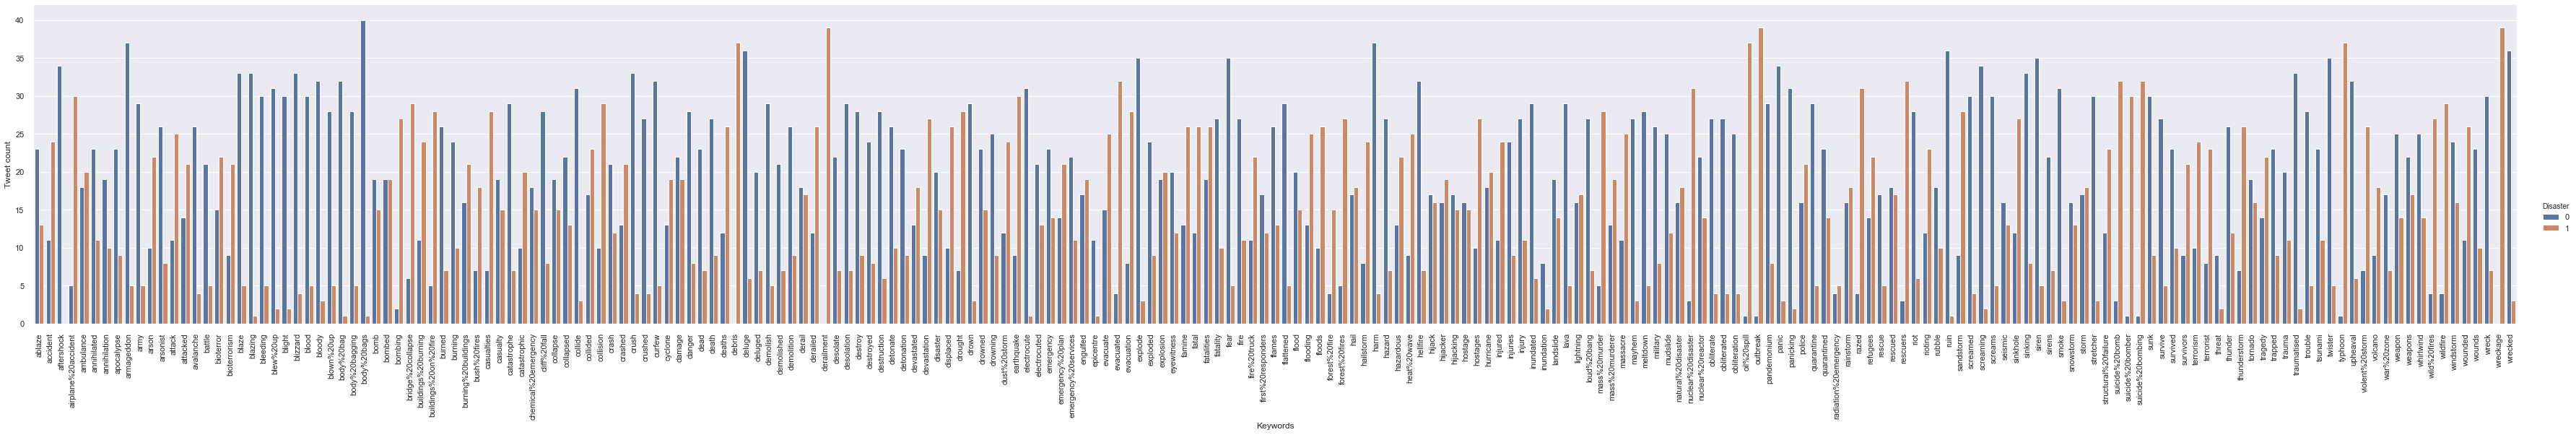

In [11]:
# Keywords Vs Target
sns.set(font_scale=1)
g = sns.catplot(x='keyword', y='target_count', hue='target',  data=Keyword_target, kind='bar', height=7, aspect=7, legend_out = True)
g.set_axis_labels("Keywords", "Tweet count");
g._legend.set_title('Disaster')
g.set_xticklabels(rotation=90)

Double click on the chart to enlarge

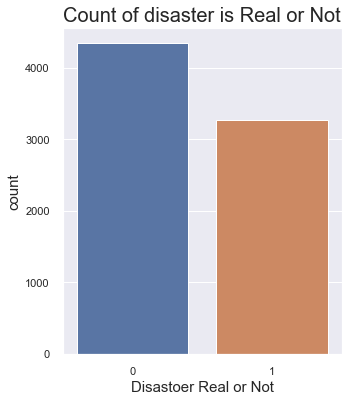

In [28]:
# distribution of real vs not real disaster, 
target = data.groupby(['target'])['target'].count()

fig, axs = plt.subplots(figsize = (5,6))
sns.barplot(x=target.index, y=target.values)

plt.title('Count of disaster is Real or Not',fontsize=20)
plt.xlabel('Disastoer Real or Not',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.show()

In [33]:
#Word count in each comment:
data['count_word']=data["text"].apply(lambda x: len(str(x).split()))

#Unique word count
data['count_unique_word']=data["text"].apply(lambda x: len(set(str(x).split())))

data.head(5)

,id,keyword,location,text,target,count_word,count_unique_word
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15


Text(0.5, 1.0, 'Not disaster tweets')

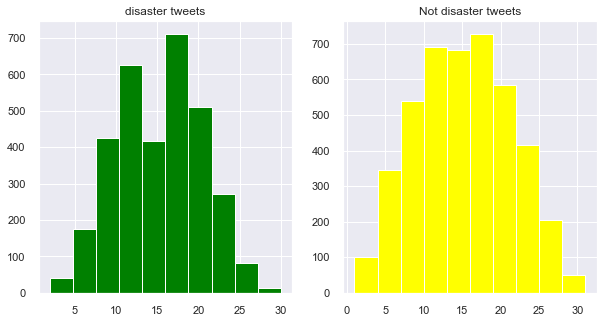

In [44]:
#words on tweets
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(data[data['target'] == 1]['count_word'],color='green')
ax1.set_title('disaster tweets')

ax2.hist(data[data['target'] == 0]['count_word'],color='yellow')
ax2.set_title('Not disaster tweets')

In [45]:
print("Total word count in the corpus: ", data['count_word'].sum())
print("Total unique word count in the corpus: ", data['count_unique_word'].sum())

Total word count in the corpus:  113461
Total unique word count in the corpus:  109176


### Data pre-processing

In [46]:
## target = Y, text = X
tweet_data = data[['text','target','count_word','count_unique_word']].copy()

In [47]:
#### cleanup
#urls
#special characters, punctuations ?
#abbreviations
#emojis
#hash tags, @users
#numbers
#stop words

In [48]:
#removes hashtags and @users, seperates on punctuations
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [49]:
# we would use gensium's stop word list
gensium_stopwords = gensim.parsing.preprocessing.STOPWORDS

In [50]:
#removes stop words and any word with 1 or 2 char length and stemming
def remove_stops(text):
    p = PorterStemmer()
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            #turns out that fire is a stop word, need to make an exception
            if word == 'fire' or (word not in gensium_stopwords and len(word) > 3):
                word = p.stem(word)
                words.append(word)
    return ' '.join(words)

In [51]:
def clean_text(text):

    # remove web addresses
    text = re.sub(r'(www\.[^\s]+)|(https?://[^\s]+)','', text)

    # Remove Emails
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # Remove emojis
    text = demoji.replace(text,'')
    
    #Remove HTML tags
    text = re.sub(r'<.*?>','',text)
    
    # Remove new line characters
    text = re.sub(r'\s+', ' ', text)
    
    #removes hashtags and @users, seperates on punctuations
    text = strip_all_entities(text)
                       
    #remove numbers (this would take care of telephones too)
    text = re.sub(r'\d+', '', text)

    #remove continuos spaces with one space character
    text = re.sub(r' +', ' ', text)
    
    # to lower case
    text = text.lower() 
    
    return text


In [52]:
tweet_data['text'] = tweet_data['text'].apply(clean_text)

In [53]:
tweet_data['text'][:5]

0    our deeds are the reason of this may allah for...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3       people receive evacuation orders in california
4    just got sent this photo from ruby as smoke fr...
Name: text, dtype: object

#### looking at the above we should be ok with the stop words, I would strip out the 1 or 2 letter words anyway

In [54]:
## remove stop words
tweet_data['text'] = tweet_data['text'].apply(remove_stops)

In [55]:
## create word frequncy
def get_word_freq(text_data):
    corpus=[]    
    for x in text_data.str.split():
        for i in x:
            corpus.append(i)

    dic=defaultdict(int)
    for word in corpus:
        dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)
    top_df = pd.DataFrame.from_dict(top)
    top_df.columns = ['word', 'freq']
    print('wrod freqency dataframe shape: ', top_df.shape)
    return top_df

def not_frequent(text_data, freq=10):
    tmp_df = get_word_freq(text_data)
    tmp_df = tmp_df[tmp_df['freq'] < freq] 
    return tmp_df['word']

In [56]:
#removes infrequent words
def remove_not_freq(text):
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word not in infreq_list:
                words.append(word)
    return ' '.join(words)

In [57]:
#get word frequency
#infreq_list = not_frequent(tweet_data['text'], 2).to_list()
#remove words with a frequency less than 10
#tweet_data['text'] = tweet_data['text'].apply(remove_not_freq)

In [58]:
get_word_freq(tweet_data['text'])

wrod freqency dataframe shape:  (9118, 2)


,word,freq
0,like,410
1,fire,355
2,bomb,236
3,peopl,199
4,time,180
...,...,...
9113,iwat,1
9114,ayyo,1
9115,overtak,1
9116,fornei,1


In [59]:
#Word count in each comment after processing:
tweet_data['post_process_cnt_wrd']=tweet_data["text"].apply(lambda x: len(str(x).split()))

#Unique word count after processing
tweet_data['post_process_cnt_uniq_wrd']=tweet_data["text"].apply(lambda x: len(set(str(x).split())))

In [60]:
tweet_data.head(10)

,text,target,count_word,count_unique_word,post_process_cnt_wrd,post_process_cnt_uniq_wrd
0,deed reason allah forgiv,1,13,13,4,4
1,forest fire near rong sask canada,1,7,7,6,6
2,resid ask shelter place notifi offic evacu she...,1,22,20,11,9
3,peopl receiv evacu order california,1,8,8,5,5
4,sent photo rubi smoke pour school,1,16,15,6,6
5,updat california close direct lake counti fire,1,18,18,7,7
6,heavi rain caus flash flood street manit color...,1,14,14,10,10
7,hill fire wood,1,15,14,3,3
8,emerg evacu happen build street,1,12,11,5,5
9,afraid tornado come area,1,10,10,4,4


In [61]:
#function for priting out the metrics
def print_metrics(model, train_test, y, y_pred):
    
    rsquared_adj = 'NA'
    print("***************************** START *******************************")
    print("Metrics output for - ", train_test, " Data")
    print("Model Used :\n ", model)
    accuray = metrics.accuracy_score(y, y_pred)
    F1_Score  = metrics.f1_score(y, y_pred)
    
    # For ROC_AUC - predict probabilities on train and test
    #predict_prob_train = nb_model.predict_proba(train_X_tfidf)[:,1]
    #predict_prob_test = nb_model.predict_proba(test_X_tfidf)[:,1]
    #print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
    #print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))
    
    print('\n')
    print("Accuray : ",accuray)
    print("F1_Score: ",F1_Score)
    print("***************************** END *******************************")
    
    df = pd.DataFrame(columns=metrics_df.columns)
    model_string = str(model).split('(')[0]
    df.loc[-1] = [model,model_string,train_test,accuray,F1_Score]
    df.index = df.index + 1
    
    return df

In [70]:
#metrics_df = pd.DataFrame(columns=["Model","Model_Name","Train_Test","Accuracy","F1_Score"])

### Split the data into train & Test

In [71]:
#### Split the data into train & Test

# split the new DataFrame into training and testing sets
y = tweet_data['target']
X = tweet_data['text']
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)
print('train_X length:' , len(train_X))
print('test_X length:' , len(test_X))
print('train_y length:' , train_y.shape)
print('test_y length:' , test_y.shape)

train_X length: 5709
test_X length: 1904
train_y length: (5709,)
test_y length: (1904,)


#### TF-IDF matrix for both train & test

In [72]:
tfidf_vect = TfidfVectorizer()
train_X_tfidf = tfidf_vect.fit_transform(train_X)

test_X_tfidf = tfidf_vect.transform(test_X)

### Naive Bayes classification

In [73]:
# building naive bayes model on TF-IDF
nb_model = naive_bayes.BernoulliNB()

In [74]:
nb_model.fit(train_X_tfidf,train_y)

BernoulliNB()

In [75]:
predict_train = nb_model.predict(train_X_tfidf)
predict_test = nb_model.predict(test_X_tfidf)

In [76]:
#print metrics for train
df = print_metrics(nb_model, 'TRAIN', train_y, predict_train)
metrics_df = metrics_df.append(df)
#print metrics for test
df = print_metrics(nb_model, 'TEST', test_y, predict_test)
metrics_df = metrics_df.append(df)

***************************** START *******************************
Metrics output for -  TRAIN  Data
Model Used :
  BernoulliNB()


Accuray :  0.8866701699071641
F1_Score:  0.8578958928179222
***************************** END *******************************
***************************** START *******************************
Metrics output for -  TEST  Data
Model Used :
  BernoulliNB()


Accuray :  0.8035714285714286
F1_Score:  0.740638002773925
***************************** END *******************************


### XGBoost Classifier

In [78]:
#parameter grid for gridsearchCV
param_grid_xgb = {'n_estimators': [700,800,900],
                  'max_depth': [ 12, 14, 16],
                 'learning_rate': [0.03,0.04,0.05]
                 }

gscv_xgb = GridSearchCV(estimator=XGBClassifier(), 
                        param_grid=param_grid_xgb, 
                        cv=3,
                        verbose=True, n_jobs=-1)

gscv_results = gscv_xgb.fit(train_X_tfidf,train_y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 15.6min finished


In [79]:
gscv_results.best_params_

{'learning_rate': 0.04, 'max_depth': 12, 'n_estimators': 800}

In [80]:
predict_train = gscv_xgb.predict(train_X_tfidf)
predict_test = gscv_xgb.predict(test_X_tfidf)

In [81]:
#print metrics for train
df = print_metrics(gscv_results.best_estimator_, 'TRAIN', train_y, predict_train)
metrics_df = metrics_df.append(df)
#print metrics for test
df = print_metrics(gscv_results.best_estimator_, 'TEST', test_y, predict_test)
metrics_df = metrics_df.append(df)

***************************** START *******************************
Metrics output for -  TRAIN  Data
Model Used :
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.04, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


Accuray :  0.9010334559467508
F1_Score:  0.8741928301046538
***************************** END *******************************
***************************** START *******************************
Metrics output for -  TEST  Data
Model Used :
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylev

### KNN

In [82]:
param_grid = {'n_neighbors': [4,5,6,7,8,9,10], 'weights': ['distance']}

model_knn_gcv = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 3, scoring = 'f1_weighted')

model_knn_gcv.fit(train_X_tfidf,train_y)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4, 5, 6, 7, 8, 9, 10],
                         'weights': ['distance']},
             scoring='f1_weighted')

In [83]:
model_knn_gcv.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [84]:
predict_train = model_knn_gcv.predict(train_X_tfidf)
predict_test = model_knn_gcv.predict(test_X_tfidf)

In [85]:
#print metrics for train
df = print_metrics(model_knn_gcv.best_estimator_, 'TRAIN', train_y, predict_train)
metrics_df = metrics_df.append(df)
#print metrics for test
df = print_metrics(model_knn_gcv.best_estimator_, 'TEST', test_y, predict_test)
metrics_df = metrics_df.append(df)

***************************** START *******************************
Metrics output for -  TRAIN  Data
Model Used :
  KNeighborsClassifier(n_neighbors=4, weights='distance')


Accuray :  0.9821334734629532
F1_Score:  0.9788732394366196
***************************** END *******************************
***************************** START *******************************
Metrics output for -  TEST  Data
Model Used :
  KNeighborsClassifier(n_neighbors=4, weights='distance')


Accuray :  0.6822478991596639
F1_Score:  0.5371078806426932
***************************** END *******************************


### ridge classifier

In [86]:
# Initializing Model
tuned_parameters = [{'alpha': [0.001,0.01,0.1,1,3, 5, 6,7,8, 9,10]}]
RidgeCV = GridSearchCV(RidgeClassifier(),
                   tuned_parameters,
                   cv=5,
                   n_jobs=-1)

RidgeCV.fit(train_X_tfidf,train_y)
print('Best combination:', RidgeCV.best_params_);

Best combination: {'alpha': 3}


In [87]:
predict_train = RidgeCV.predict(train_X_tfidf)
predict_test = RidgeCV.predict(test_X_tfidf)

In [88]:
#print metrics for train
df = print_metrics(RidgeCV.best_estimator_, 'TRAIN', train_y, predict_train)
metrics_df = metrics_df.append(df)
#print metrics for test
df = print_metrics(RidgeCV.best_estimator_, 'TEST', test_y, predict_test)
metrics_df = metrics_df.append(df)

***************************** START *******************************
Metrics output for -  TRAIN  Data
Model Used :
  RidgeClassifier(alpha=3)


Accuray :  0.8906988964792433
F1_Score:  0.8630377524143987
***************************** END *******************************
***************************** START *******************************
Metrics output for -  TEST  Data
Model Used :
  RidgeClassifier(alpha=3)


Accuray :  0.7951680672268907
F1_Score:  0.737550471063257
***************************** END *******************************


### stochastic gradient descent (SGD) Classifier

In [89]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
    "max_iter": [1000]
}

sgdc = GridSearchCV(SGDClassifier(),
                   params,
                   cv=5,
                   n_jobs=-1)

sgdc.fit(train_X_tfidf,train_y)

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                                  'modified_huber'],
                         'max_iter': [1000], 'penalty': ['l2', 'l1', 'none']})

In [90]:
print('Best combination:', sgdc.best_params_);

Best combination: {'alpha': 0.001, 'loss': 'log', 'max_iter': 1000, 'penalty': 'none'}


In [91]:
predict_train = sgdc.predict(train_X_tfidf)
predict_test = sgdc.predict(test_X_tfidf)

In [92]:
#print metrics for train
df = print_metrics(sgdc, 'TRAIN', train_y, predict_train)
metrics_df = metrics_df.append(df)
#print metrics for test
df = print_metrics(sgdc, 'TEST', test_y, predict_test)
metrics_df = metrics_df.append(df)

***************************** START *******************************
Metrics output for -  TRAIN  Data
Model Used :
  GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                                  'modified_huber'],
                         'max_iter': [1000], 'penalty': ['l2', 'l1', 'none']})


Accuray :  0.8686284813452444
F1_Score:  0.8380129589632831
***************************** END *******************************
***************************** START *******************************
Metrics output for -  TEST  Data
Model Used :
  GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                                  'modified_huber'],
                         'max_iter': [1000], 'penalty': ['l2', 'l1', 'none']})


A

### Stacked Classifier

In [93]:
## would train the stacked and voting classifiers on whole of the train data

tfidf_vect_train = TfidfVectorizer()
X_tfidf = tfidf_vect_train.fit_transform(X)

In [94]:
clf1 = KNeighborsClassifier(n_neighbors=4, weights='distance')
clf2 = RidgeClassifier(alpha=5)
clf3 = naive_bayes.BernoulliNB()
clf4 =  XGBClassifier(learning_rate=0.04, max_depth= 14, n_estimators= 800)
clf5 = SGDClassifier(alpha=0.001, loss='log', max_iter=1000, penalty='none')
lr1 = LogisticRegression()

In [95]:
from mlxtend.classifier import StackingCVClassifier
RANDOM_SEED = 1234
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4,clf5],
                            meta_classifier=lr1,
                            random_state=RANDOM_SEED)

In [96]:
print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, clf4,clf5,sclf ], ['KNN', 'Ridge', 'Naive Bayes','XGBoost','SGD','Stacked']):
    scores = model_selection.cross_val_score(clf, X_tfidf, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.56 (+/- 0.01) [KNN]
Accuracy: 0.70 (+/- 0.03) [Ridge]
Accuracy: 0.72 (+/- 0.04) [Naive Bayes]
Accuracy: 0.66 (+/- 0.03) [XGBoost]
Accuracy: 0.70 (+/- 0.03) [SGD]
Accuracy: 0.71 (+/- 0.04) [Stacked]


In [97]:
sclf.fit(X_tfidf, y)

StackingCVClassifier(classifiers=[KNeighborsClassifier(n_neighbors=4,
                                                       weights='distance'),
                                  RidgeClassifier(alpha=5), BernoulliNB(),
                                  XGBClassifier(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                gamma=None, gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=0.04,
                                                max_delta_step=Non...
                                                min_child_weight=None,
                                                missin

In [98]:
predict_y = sclf.predict(X_tfidf)

In [99]:
#print metrics for train
df = print_metrics(sclf, 'TRAIN', y, predict_y)
metrics_df = metrics_df.append(df)


***************************** START *******************************
Metrics output for -  TRAIN  Data
Model Used :
  StackingCVClassifier(classifiers=[KNeighborsClassifier(n_neighbors=4,
                                                       weights='distance'),
                                  RidgeClassifier(alpha=5), BernoulliNB(),
                                  XGBClassifier(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                gamma=None, gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=0.04,
                                                max_delta_step=Non...
        

### Voting Classifier

In [100]:
clf6 = RidgeClassifier(alpha=3)
clf7 = naive_bayes.BernoulliNB()
clf8 = XGBClassifier(learning_rate=0.04, max_depth= 14, n_estimators= 800)
clf9 = SGDClassifier(alpha=0.001, loss='log', max_iter=1000, penalty='none')
clf10 = KNeighborsClassifier(n_neighbors=4, weights='distance')
lr2 = LogisticRegression()

In [101]:
eclf = VotingClassifier(estimators=[('lr', lr2), ('xgb', clf8), ('nb', clf7),('ridge', clf6),('knn', clf10),('SGD', clf9) ],voting='hard')

In [102]:
for clf, label in zip([clf6, clf7, clf8, clf9, clf10, lr2, eclf], ['Ridge','naive Bayes','XGBoost', 'SGD', 'KNN', 'Logistic Regression','Ensemble']):
    scores = model_selection.cross_val_score(clf, X_tfidf, y, scoring='accuracy', cv=3)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.70 (+/- 0.03) [Ridge]
Accuracy: 0.72 (+/- 0.04) [naive Bayes]
Accuracy: 0.66 (+/- 0.03) [XGBoost]
Accuracy: 0.70 (+/- 0.03) [SGD]
Accuracy: 0.56 (+/- 0.01) [KNN]
Accuracy: 0.70 (+/- 0.03) [Logistic Regression]
Accuracy: 0.70 (+/- 0.03) [Ensemble]


In [103]:
eclf.fit(X_tfidf, y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.04,
                                            max_delta_step=None, max_depth=14,
                                            min_child_weight=None, missing=nan,
                                            monotone_constr...
                                            n_estimators=800, n_jobs=None,
                                            num_parallel_tree=None,
                               

In [104]:
predict_y = eclf.predict(X_tfidf)

In [105]:
#print metrics for train
df = print_metrics(eclf, 'TRAIN', y, predict_y)
metrics_df = metrics_df.append(df)


***************************** START *******************************
Metrics output for -  TRAIN  Data
Model Used :
  VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.04,
                                            max_delta_step=None, max_depth=14,
                                            min_child_weight=None, missing=nan,
                                            monotone_constr...
                                            n_estimators=

In [106]:
#save to file
metrics_df.to_csv("models.csv")

### Predicting on TEST data for submission

In [107]:
# read test data into a DataFrame
test_data = pd.read_csv('data/test.csv')

In [108]:
test_data.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [109]:
test_data['text'] = test_data['text'].apply(clean_text)

In [110]:
## remove stop words
test_data['text'] = test_data['text'].apply(remove_stops)

In [111]:
#get word frequency
#infreq_list = not_frequent(test_data['text'], 2).to_list()
#remove words with a frequency less than 2
#test_data['text'] = test_data['text'].apply(remove_not_freq)

In [112]:
test_X_tfidf = tfidf_vect_train.transform(test_data['text'])

In [113]:
predicted_y = sclf.predict(test_X_tfidf)

In [114]:
predicted_df = pd.DataFrame()
predicted_df['id'] = test_data['id']
predicted_df['target'] = predicted_y
predicted_df.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [115]:
predicted_df.to_csv("sclf_sub.csv", index=False, header=True)